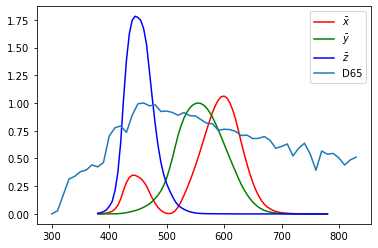

In [1]:
# Now that we have a model for reducing dimensions, let's observe some quantities
import numpy as np
import matplotlib.pyplot as plt
cmf = np.loadtxt("../data/cie-cmf.txt")
D65 = np.loadtxt("../data/d65.m", delimiter=",")
fig, ax = plt.subplots()
ax.plot(cmf[:, 0], cmf[:, 1], 'r', label="$\\bar x$")
ax.plot(cmf[:, 0], cmf[:, 2], 'g', label="$\\bar y$")
ax.plot(cmf[:, 0], cmf[:, 3], 'b', label="$\\bar z$")
ax.plot(D65[:, 0], D65[:, 1] / np.max(D65[:, 1]), label='D65')
plt.legend()

In [2]:
fake_spectrum = cmf[:, 1] #/ np.max(cmf[:,2])
XYZ = np.sum(fake_spectrum[:, np.newaxis] * cmf[:, 1:], axis=0)
XYZ /= np.sum(XYZ)
M = np.loadtxt("../data/M.txt")
MI = np.linalg.inv(M)
rgb = M @ XYZ
print(rgb)

[0.37545988 0.38264221 0.16816271]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


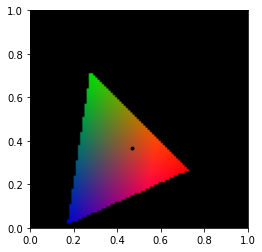

In [3]:
x = np.linspace(0, 1.0, 100)
X, Y = np.meshgrid(x, x)
xyz = np.stack((X.flatten(), Y.flatten(), (1-X-Y).flatten()), axis=-1).reshape(-1, 3)
rgb = np.zeros_like(xyz)
for i in range(xyz.shape[0]):
    rgb[i] = MI @ xyz[i]
    if np.any(rgb[i] < 0):
        rgb[i] = 0
plt.imshow(np.flipud(rgb.reshape(100, 100, 3)), extent=[0, 1, 0, 1])
plt.plot(XYZ[0], XYZ[1], 'k.')
plt.savefig("../data/obj.png")

In [4]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(in_features, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, out_features)
    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X))
        return X

class Decoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(in_features, 64)
        self.l2 = nn.Linear(64, 256)
        self.l3 = nn.Linear(256, out_features)

    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X))
        return X

class AutoEncoder(nn.Module):
    def __init__(self, features, latent_features=2, variationnal=False, smoothing=15):
        super(AutoEncoder, self).__init__()
        if variationnal:
            self.enc = Encoder(features, latent_features*2)
            self.dec = Decoder(latent_features, features+smoothing-1)
        else:
            self.enc = Encoder(features, latent_features)
            self.dec = Decoder(latent_features, features+smoothing-1)

        self.latent_features = latent_features
        self.variationnal = variationnal
        self.smoothing = smoothing
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=self.smoothing)
    def forward(self, X):
        bs = X.shape[0]
        if self.variationnal:
            X = self.enc(X).view(-1, 2, self.latent_features)
            mu = X[:, 0, :]
            logvar = (X[:, 1, :] - 1) * 5
            X = self.reparameterize(mu, logvar)
            return self.c1(self.dec(X).view(bs, 1, -1)).view(bs, -1), mu, logvar
        else:
            return self.c1(self.dec(self.enc(X)).view(bs, 1, -1)).view(bs, -1)
    
    def reconstruct(self, X):
        bs = X.shape[0]
        recons = self.dec(X).view(bs, 1, -1)
        recons = self.c1(recons)
        return (recons.view(bs, -1))
    def encode(self, X, std=False):
        code = self.enc(X)
        if self.variationnal:
            view = code.view(-1, 2, self.latent_features)
            if std:
                return view[:, 0, :], view[:, 1, :]
            else:
                return view[:, 0, :]
        else:
            return self.enc(X)

    def reparameterize(self, latent_mean, latent_logvar):
        std = torch.exp(0.5*latent_logvar)
        eps = torch.randn_like(std)
        sample = latent_mean + (eps * std)
        return sample

In [5]:
import torch, pickle
from scipy.interpolate import interp1d
model = AutoEncoder(862, 2, variationnal=True)
model.load_state_dict(torch.load("vae_05.model"))

scaler = pickle.load(open("vae_05.scaler", "rb"))
x = np.linspace(-1, 1.0, 100)
from itertools import product
latent = np.array(list(product(x, x)), dtype=np.float32)
spectrums = model.reconstruct(torch.from_numpy(latent)).detach().numpy()
spectrums = scaler.inverse_transform(spectrums).reshape(-1, 2, spectrums.shape[-1]//2)

wl = np.linspace(200, 2350, spectrums[0].shape[1], endpoint=True)
mask = np.logical_and(wl >= 380, wl <= 780)
wl = wl[mask]
interp1 = interp1d(cmf[:, 0], cmf[:, 1])
interp2 = interp1d(cmf[:, 0], cmf[:, 2])
interp3 = interp1d(cmf[:, 0], cmf[:, 3])
interp_d65 = interp1d(D65[:,0], D65[:,1] / np.max(D65[:,1]))
cmfi = np.zeros((wl.shape[0], 3))
cmfi[:, 0] = interp1(wl)
cmfi[:, 1] = interp2(wl)
cmfi[:, 2] = interp3(wl)
d65 = interp_d65(wl)
colors = []
for spec, lat in zip(spectrums, latent):
    #if lat[0] == -1.0:
        #colors.append((0, 0,0))
    #    continue
    XYZ = np.sum(np.flip(spec[1])[mask, np.newaxis] * cmfi , axis=0) #  * d65[:, np.newaxis]
    #XYZ /= XYZ.sum()
    RGB = MI @ XYZ
    colors.append(RGB)
colors= np.asarray(colors)

(0.0, 1.0, 0.0, 1.0)

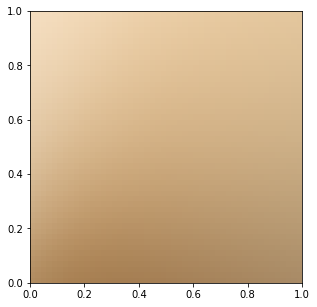

In [6]:
colors = colors.reshape((100, 100, 3))
colors /= colors.max()
colors = np.swapaxes(colors, 0, 1)
fig, ax = plt.subplots(figsize=(5, 5))
np.save("../data/colorimetry.npy", np.flipud(colors))
import imageio
img1 = imageio.imread("../images/chevre.png")
img2 = imageio.imread("../images/agneau.png")

ax.imshow(np.flipud(colors), extent=[-1, 1, -1, 1])
#ax.imshow(img1, extent=[0.1, 0.2, 0.1, 0.2])
#ax.imshow(img2, extent=[0.7, 0.8, 0.7, 0.8])
plt.axis([0, 1, 0, 1])

In [7]:
scaler.min_.shape

(862,)